In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, get_scorer
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.svm import SVR
from sklearn import linear_model
import datetime as dt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

from utilities import statistics_utility as stats


c:\Users\nelso\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\nelso\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\nelso\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
# weatherfootdata = pd.read_csv("./data_files/FootTrafficWeather_July2022_Melbourne.csv")
#weatherfootdata = pd.read_csv("./data_files/FootTrafficWeatherMelb2_20130101_20220701_v3.csv")
weatherfootdata = pd.read_csv("./data_files/FootTrafficWeatherMelb3_20130101_20220701.csv")

Basic Summary Statistics of Total People - total_people:
  Records: 3499
  Null Records: 0   Zero Records: 0
  Min: 10309.0   Max: 1151467.0
  Mean: 481666.6893398114   Median: 490185.0
  Standard Deviation:209496.17609257743
Quantile Statistics:
  Q1: 318387.0   Q3: 641384.0   IQR: 322997.0
  Lower Fence: -166108.5   Upper Fence: 1125879.5
Outlier Counts:
  Lower Outliers: 0   Upper Outliers: 1
  Total Outliers: 1


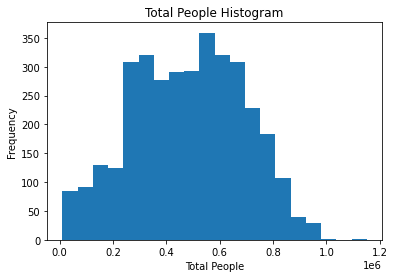

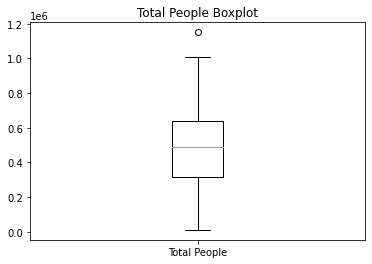

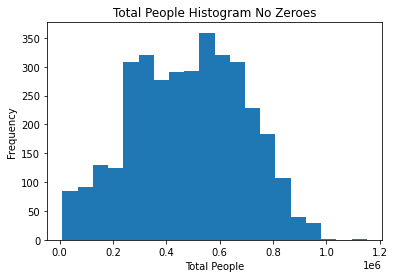

In [5]:
stats.print_stats_and_outliers(weatherfootdata["total_people"], "total_people", "Total People")

In [ ]:
weatherfootdata

In [ ]:
plt.figure(figsize=(20,10))
i=1
for col in weatherfootdata.columns:
    if col != 'date':
        if weatherfootdata[col].dtypes == np.int64 or weatherfootdata[col].dtypes == np.float64 and col != 'total_people':
            plt.subplot(2,3,i)
            sns.scatterplot(x=col , y = 'total_people', data = weatherfootdata, palette="Purples")
            i = i+1
            plt.title(col)

plt.xticks(rotation='vertical')
plt.show()

In [ ]:
le = preprocessing.LabelEncoder()
weatherfootdata['rain_quality']=le.fit_transform(weatherfootdata['rain_quality'])
weatherfootdata['max_temp_quality']=le.fit_transform(weatherfootdata['max_temp_quality'])
weatherfootdata['min_temp_quality']=le.fit_transform(weatherfootdata['min_temp_quality'])
weatherfootdata['solar_exp']=le.fit_transform(weatherfootdata['solar_exp'])


weatherfootdata['date'] = pd.to_datetime(weatherfootdata['date'])
weatherfootdata['date']=weatherfootdata['date'].map(dt.datetime.toordinal)
weatherfootdata = weatherfootdata[weatherfootdata["total_rain"].notna()]
weatherfootdata = weatherfootdata[weatherfootdata["max_temp"].notna()]
weatherfootdata = weatherfootdata[weatherfootdata["min_temp"].notna()]
weatherfootdata

In [ ]:
weatherfootdata.info()

In [ ]:
weatherfootdata

In [ ]:
y = weatherfootdata['total_people']
x = weatherfootdata[['date','total_rain', 'rain_quality', 'max_temp',
       'max_temp_quality', 'min_temp', 'min_temp_quality', 'solar_exp',
       'WeekDay', 'population_annual', 'population_change_annual']]

In [ ]:
weatherfootdata.columns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=2)

In [ ]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train,y_train)
# Predicting the Salary for the Test values
y_pred = lr.predict(X_test)
c = [i for i in range (1,len(y_test)+1,1)]
plt.plot(c,y_test,color='r',linestyle='-')
plt.plot(c,y_pred,color='b',linestyle='--') 
plt.title('Prediction')
plt.xlabel('All Records')
plt.ylabel('Total People Detected')
plt.show()

In [ ]:
error_values = [i for i in range(1,len(y_test)+1,1)]
error_margin = y_test - y_pred
plt.plot(error_values, error_margin, color='green', linestyle='-')
plt.title('Error Value')
plt.ylabel('Error')
plt.show()

In [ ]:
print("RMSE",np.log(np.sqrt(mean_squared_error(y_test,y_pred))))
print("MAE",mean_absolute_error(y_test,y_pred))

In [ ]:
# Done on v3 of data
models = [LinearRegression(), linear_model.Lasso(alpha=0.1, max_iter=10000), SVR()]
cv = KFold(n_splits=5)
names = ["Linear Regression", "Lasso Regression", "Support Vector Regression"]
for model, name in zip(models, names):
    print(name)
    for score in ["neg_mean_absolute_error", "neg_root_mean_squared_error"]:
        print (score, names),
        print (cross_val_score(model, x, y, scoring=score, cv=cv).max())

In [ ]:
alphas = np.linspace(0.01,500,100)
lasso = linear_model.Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

In [ ]:
# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model
model.fit(X_train, y_train)
LassoCV(cv=5, max_iter=10000, random_state=0)

# Set best alpha
lasso_best = linear_model.Lasso(alpha=model.alpha_)
print("Best Value Of Alpha: ", lasso_best.fit(X_train, y_train))
print(list(zip(lasso_best.coef_, x)))

In [ ]:
# polynomial features added, end results prove to be worst

poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
X_train_poly = poly.fit_transform(X_train)
polynomial_column_names = poly.get_feature_names(input_features = X_train.columns)
X_train_poly = pd.DataFrame(data = X_train_poly, columns = polynomial_column_names )
X_train_poly.columns = X_train_poly.columns.str.replace(' ', '_')
X_train_poly.columns = X_train_poly.columns.str.replace('^', '_')

In [ ]:
sc = StandardScaler()
X_train_poly_scaled = sc.fit_transform(X_train_poly)
X_train_poly_scaled = pd.DataFrame(data = X_train_poly_scaled, columns = X_train_poly.columns)
X_test_poly = poly.transform(X_test)
X_test_poly_scaled = sc.transform(X_test_poly)

In [ ]:
lasso_params = {'fit__alpha':[0.005, 0.01, 0.03, 0.05, 0.1, 0.5]}
ridge_params = {'fit__alpha':[500, 550, 580, 600, 620, 650, 800]}

pipe1 = Pipeline([('poly', PolynomialFeatures()),
                 ('fit', linear_model.Lasso())])
pipe2 = Pipeline([('poly', PolynomialFeatures()),
                 ('fit', linear_model.Ridge())])

models3 = {'Lasso': GridSearchCV(pipe1, param_grid=lasso_params).fit(x,y).best_estimator_ ,
           'Ridge': GridSearchCV(pipe2, param_grid=ridge_params).fit(x,y).best_estimator_,}

In [ ]:
models3

In [ ]:
from sklearn.metrics import mean_squared_error
models = [linear_model.Lasso(alpha=0.005), linear_model.Ridge(alpha=650)]
cv = KFold(n_splits=5)
names = ["Lasso Regression", "Ridge Regression"]
for model, name in zip(models, names):
    model.fit(X_train_poly_scaled, y_train)
    y_pred = model.predict(X_test_poly_scaled)
    mse = mean_squared_error(y_pred, y_test)
    print(mse)

    # POLYNOMIAL FEATURING DOES NOT IMPROVE RESULTS

In [ ]:
# Done on v3 of data
models = [LinearRegression(), linear_model.Lasso(max_iter=10000), SVR()]
cv = KFold(n_splits=5)
names = ["Linear Regression", "Lasso Regression", "Support Vector Regression"]
for model, name in zip(models, names):
    print(name)
    for score in ["neg_mean_absolute_error", "neg_root_mean_squared_error"]:
        print (score, names),
        print (cross_val_score(model, x, y, scoring=score, cv=cv).max())